In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import stats
import seaborn as sns
%matplotlib inline

Text(0, 0.5, '$f(x)$')

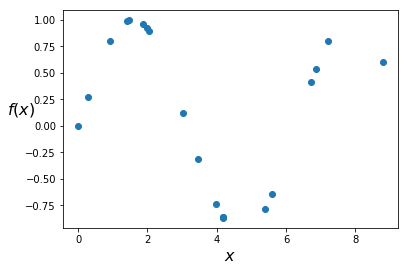

In [2]:
np.random.seed(1)
x = np.random.uniform(0, 10, size=20)
y = np.sin(x)
plt.plot(x, y, 'o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)

In [3]:
def gauss_kernel(x, n_knots=5, w=2):
    knots = np.linspace(np.floor(x.min()), np.ceil(x.max()), n_knots)
    return np.array([np.exp(-(x-k)**2/w) for k in knots])

In [5]:
n_knots=5
with pm.Model() as kernel_model:
    gamma = pm.Cauchy('gamma', alpha=0, beta=1, shape=n_knots)
    sd = pm.Uniform('sd', 0, 10)
    mu = pm.math.dot(gamma, gauss_kernel(x, n_knots))
    y1 = pm.Normal('y1', mu=mu, sd=sd, observed=y)
    kernel_trace = pm.sample(10000, step=pm.Metropolis(), chains=1)
chain = kernel_trace[5000:]
pm.traceplot(chain)

Sequential sampling (1 chains in 1 job)

CompoundStep

>Metropolis: [sd]

>Metropolis: [gamma]

  0%|          | 0/10500 [00:00<?, ?it/s]

  4%|▍         | 395/10500 [00:00<00:02, 3914.89it/s]

  8%|▊         | 846/10500 [00:00<00:02, 4066.37it/s]

 12%|█▏        | 1247/10500 [00:00<00:02, 4038.31it/s]

 16%|█▌        | 1697/10500 [00:00<00:02, 4156.21it/s]

 21%|██        | 2160/10500 [00:00<00:01, 4277.18it/s]

 25%|██▍       | 2616/10500 [00:00<00:01, 4347.10it/s]

 29%|██▉       | 3079/10500 [00:00<00:01, 4416.91it/s]

 34%|███▎      | 3537/10500 [00:00<00:01, 4452.92it/s]

 38%|███▊      | 3995/10500 [00:00<00:01, 4478.49it/s]

 43%|████▎     | 4464/10500 [00:01<00:01, 4528.11it/s]

 47%|████▋     | 4935/10500 [00:01<00:01, 4569.23it/s]

 52%|█████▏    | 5410/10500 [00:01<00:01, 4609.93it/s]

 56%|█████▌    | 5883/10500 [00:01<00:00, 4633.07it/s]

 61%|██████    | 6353/10500 [00:01<00:00, 4640.58it/s]

 65%|██████▍   | 6819/10500 [00:01<00:00, 4633.96it/s]

 69%|██████▉   | 7295/10500 [00:01<00:00, 4658.76it/s]

 74%|███████▍  | 7767/10500 [00:01<00:00, 4664.54it/s]

 78%|███████▊  | 8242/10500 [00:01<00:00, 4677.41it/s]

 83%|████████▎ | 8714/10500 [00:01<00:00, 4677.61it/s]

 88%|████████▊ | 9190/10500 [00:02<00:00, 4689.56it/s]

 92%|█████████▏| 9663/10500 [00:02<00:00, 4689.09it/s]

 97%|█████████▋| 10133/10500 [00:02<00:00, 4679.77it/s]

100%|██████████| 10500/10500 [00:02<00:00, 4565.92it/s]

Only one chain was sampled, this makes it impossible to run some convergence checks

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002232ED067B8>,
      dtype=object)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:01<01:44,  1.06s/it]

100%|██████████| 100/100 [00:01<00:00, 90.59it/s]

Text(0, 0.5, '$f(x)$')

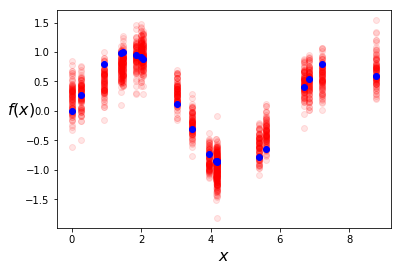

In [6]:
ppc = pm.sample_ppc(chain, model=kernel_model, samples=100)
plt.plot(x, ppc['y1'].T, 'ro', alpha=0.1)
plt.plot(x, y, 'bo')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)

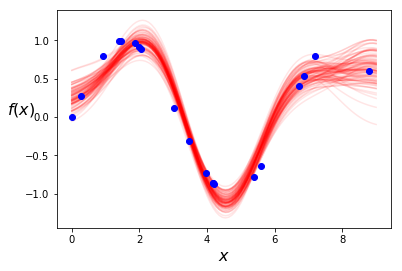

In [7]:
new_x = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)
k = gauss_kernel(new_x, n_knots)
gamma_pred = chain['gamma']
for i in range(100):
    idx = np.random.randint(0, len(gamma_pred))
    y_pred = np.dot(gamma_pred[idx], k)
    plt.plot(new_x, y_pred, 'r-', alpha=0.1)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)
plt.plot(x, y, 'bo')

In [8]:
squared_distance = lambda x, y: np.array([[(x[i] - y[j])**2 for i in range(len(x))] for j in range(len(y))])
np.random.seed(1)
test_points = np.linspace(0, 10, 100)
cov = np.exp(-squared_distance(test_points, test_points))
plt.plot(test_points, stats.multivariate_normal.rvs(cov=cov, size=6).T)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)

Text(0, 0.5, '$f(x)$')

Text(0, 0.5, '$f(x)$')

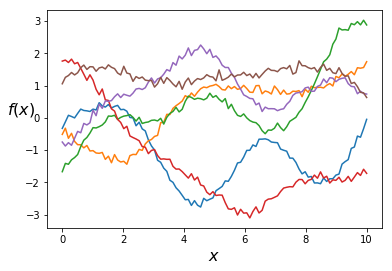

In [9]:
np.random.seed(1)
eta = 1.5
rho = 0.2
sigma = 0.007

D = squared_distance(test_points, test_points)

cov = eta * np.exp(-rho * D)
diag = eta + sigma

np.fill_diagonal(cov, diag)
for i in range(6):
    plt.plot(test_points, stats.multivariate_normal.rvs(cov=cov))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)

Text(0, 0.5, '$f(x)$')

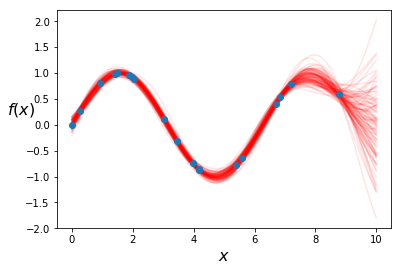

In [10]:
np.random.seed(1)

K_oo = eta * np.exp(-rho * D)

D_x = squared_distance(x, x)
K = eta * np.exp(-rho * D_x)
diag_X = eta + sigma
np.fill_diagonal(K, diag_X)

D_off_diag = squared_distance(x, test_points)
K_o = eta * np.exp(-rho * D_off_diag)

mu_post = np.dot(np.dot(K_o, np.linalg.inv(K)), y)
SIGMA_post = K_oo - np.dot(np.dot(K_o, np.linalg.inv(K)), K_o.T)

for i in range(100):
    fx = stats.multivariate_normal.rvs(mean=mu_post, cov=SIGMA_post)
    plt.plot(test_points, fx, 'r-', alpha=0.1)
    
plt.plot(x, y, 'o')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)

Text(0, 0.5, '$f(x)$')

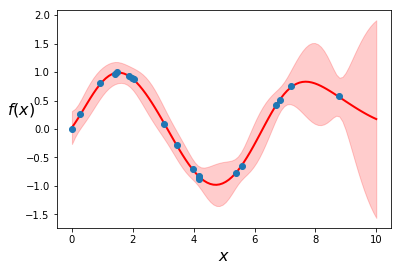

In [12]:
np.random.seed(1)
eta = 1
rho = 0.5
sigma = 0.03

# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(x).flatten()

# Define the kernel
def kernel(a, b):
    """ GP squared exponential kernel """
    D = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return eta * np.exp(- rho * D)

N = 20         # number of training points.
n = 100         # number of test points.

# Sample some input points and noisy versions of the function evaluated at
# these points. 
X = np.random.uniform(0, 10, size=(N,1))
y = f(X) + sigma * np.random.randn(N)

K = kernel(X, X)
L = np.linalg.cholesky(K + sigma * np.eye(N))

# points we're going to make predictions at.
Xtest = np.linspace(0, 10, n).reshape(-1,1)

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest))
mu = np.dot(Lk.T, np.linalg.solve(L, y))

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest)
sd_pred = (np.diag(K_) - np.sum(Lk**2, axis=0))**0.5


plt.fill_between(Xtest.flat, mu - 2 * sd_pred, mu + 2 * sd_pred, color="r", alpha=0.2)
plt.plot(Xtest, mu, 'r', lw=2)
plt.plot(x, y, 'o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)

In [14]:
import theano.tensor as tt
with pm.Model() as GP:
    mu = np.zeros(N)
    eta = pm.HalfCauchy('eta', 5)
    rho = pm.HalfCauchy('rho', 5)
    sigma = pm.HalfCauchy('sigma', 5)
    
    D = squared_distance(x, x)
    
    K = tt.fill_diagonal(eta * pm.math.exp(-rho * D), eta + sigma)
    
    obs = pm.MvNormal('obs', mu, cov=K, observed=y)

    test_points = np.linspace(0, 10, 100)
    D_pred = squared_distance(test_points, test_points)
    D_off_diag = squared_distance(x, test_points)
    
    K_oo = eta * pm.math.exp(-rho * D_pred)
    K_o = eta * pm.math.exp(-rho * D_off_diag)
    
    mu_post = pm.Deterministic('mu_post', pm.math.dot(pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), y))
    SIGMA_post = pm.Deterministic('SIGMA_post', K_oo - pm.math.dot(pm.math.dot(K_o, tt.nlinalg.matrix_inverse(K)), K_o.T))
    
    start = pm.find_MAP()
    trace = pm.sample(1000, start=start)

C:\ProgramData\Anaconda3\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')


C:\ProgramData\Anaconda3\lib\site-packages\theano\tensor\basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


C:\ProgramData\Anaconda3\lib\site-packages\theano\tensor\basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


C:\ProgramData\Anaconda3\lib\site-packages\theano\tensor\basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


C:\ProgramData\Anaconda3\lib\site-packages\theano\tensor\basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


  0%|          | 0/5000 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\theano\tensor\basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


logp = -48.653, ||grad|| = 8.6576:   0%|          | 0/5000 [00:00<?, ?it/s]

logp = 11.061, ||grad|| = 13.939:   0%|          | 10/5000 [00:00<00:07, 667.32it/s]

logp = 15.78, ||grad|| = 1.6532e-05:   0%|          | 20/5000 [00:00<00:06, 741.48it/s]

logp = 15.78, ||grad|| = 1.6532e-05: 100%|██████████| 22/22 [00:00<00:00, 786.48it/s]  

Auto-assigning NUTS sampler...

Initializing NUTS using jitter+adapt_diag...

C:\ProgramData\Anaconda3\lib\site-packages\theano\tensor\basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


C:\ProgramData\Anaconda3\lib\site-packages\theano\tensor\basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


Multiprocess sampling (4 chains in 4 jobs)

NUTS: [sigma, rho, eta]

In [ ]:
varnames = ['eta', 'rho', 'sigma']
chain = trace[100:]
pm.traceplot(chain, varnames)

In [ ]:
y_pred = [np.random.multivariate_normal(m, S) for m,S in zip(chain['mu_post'][::5], chain['SIGMA_post'][::5])]

for yp in y_pred:
    plt.plot(test_points, yp, 'r-', alpha=0.1)

plt.plot(x, y, 'bo')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)